(mmm_multidimensional_example)=
# MMM Multidimensional Example Notebook

In [29]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
data_path = data_dir / "mmm_example.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["date_week"])

raw_data_df = raw_data_df.rename(columns={"date_week": "date"})

raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       179 non-null    datetime64[ns]
 1   y          179 non-null    float64       
 2   x1         179 non-null    float64       
 3   x2         179 non-null    float64       
 4   event_1    179 non-null    float64       
 5   event_2    179 non-null    float64       
 6   dayofyear  179 non-null    int64         
 7   t          179 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.3 KB


In [31]:
a_data_df = raw_data_df.copy().assign(geo="geo_a")

b_data_df = raw_data_df.copy().assign(geo="geo_b")

rng = np.random.default_rng(42)

b_data_df["y"] = b_data_df["y"] + 1_000 * rng.normal(size=len(b_data_df))

data_df = pd.concat([a_data_df, b_data_df])

data_df.head()

,date,y,x1,x2,event_1,event_2,dayofyear,t,geo
0,2018-04-02,3984.662237,0.318580,0.0,0.0,0.0,92,0,geo_a
1,2018-04-09,3762.871794,0.112388,0.0,0.0,0.0,99,1,geo_a
2,2018-04-16,4466.967388,0.292400,0.0,0.0,0.0,106,2,geo_a
3,2018-04-23,3864.219373,0.071399,0.0,0.0,0.0,113,3,geo_a
4,2018-04-30,4441.625278,0.386745,0.0,0.0,0.0,120,4,geo_a


/Users/juanitorduz/Documents/envs/pymc-marketing-env/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


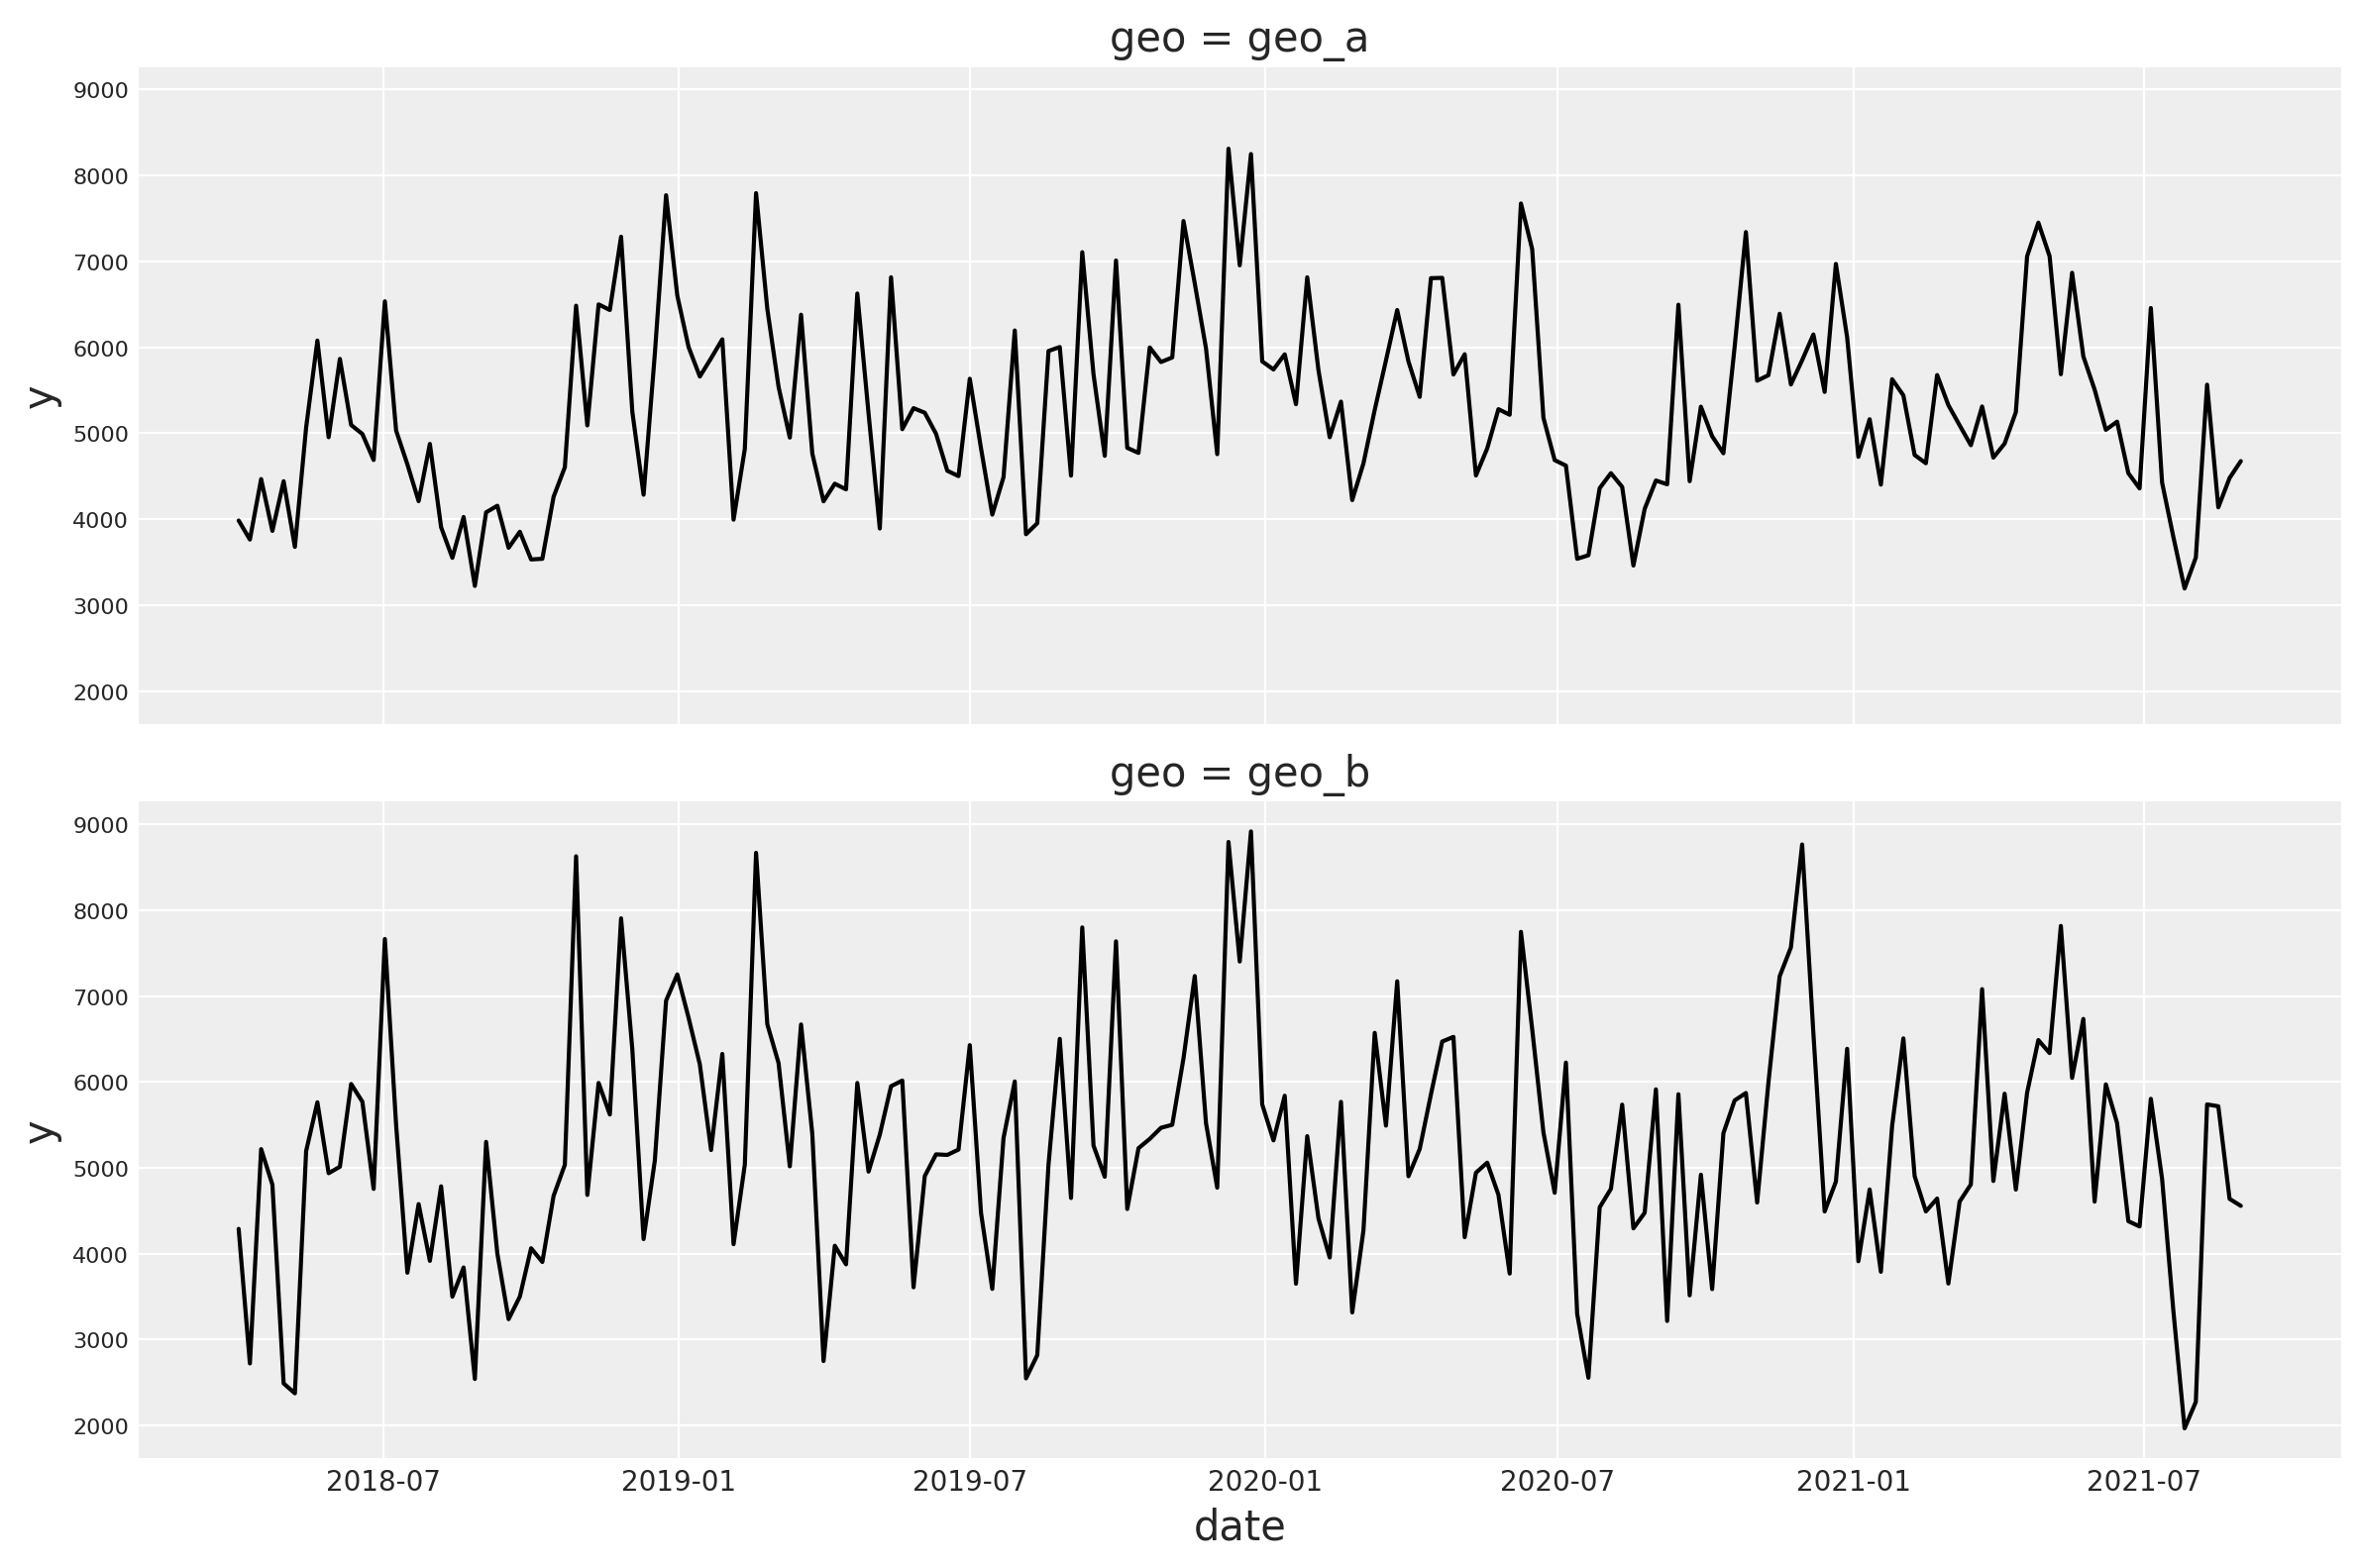

In [32]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

In [33]:
channel_columns = ["x1", "x2"]
n_channels = len(channel_columns)

sum_spend_geo_channel = data_df.groupby(["geo"]).agg({"x1": "sum", "x2": "sum"})

spend_share = (
    sum_spend_geo_channel.to_numpy() / sum_spend_geo_channel.sum(axis=1).to_numpy()
)

prior_sigma = n_channels * spend_share

In [108]:
saturation = LogisticSaturation(
    priors={
        "beta": Prior("HalfNormal", sigma=prior_sigma, dims=("channel", "geo")),
        "lam": Prior(
            "Gamma",
            mu=Prior("HalfNormal", sigma=5, dims="geo"),
            sigma=Prior("HalfNormal", sigma=2, dims="geo"),
            dims=("channel", "geo"),
        ),
    }
)

saturation.model_config

{'saturation_lam': Prior("Gamma", mu=Prior("HalfNormal", sigma=5, dims="geo"), sigma=Prior("HalfNormal", sigma=2, dims="geo"), dims=("channel", "geo")),
 'saturation_beta': Prior("HalfNormal", sigma=[[1.31263903 0.68736097]
  [1.31263903 0.68736097]], dims=("channel", "geo"))}

In [109]:
adstock = GeometricAdstock(
    priors={"alpha": Prior("Beta", alpha=2, beta=3, dims="channel")}, l_max=8
)

adstock.model_config

{'adstock_alpha': Prior("Beta", alpha=2, beta=3, dims="channel")}

In [110]:
model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.2, dims="geo"),
    "gamma_control": Prior("Normal", mu=0, sigma=0.05, dims="control"),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2, dims=("geo", "fourier_mode")),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=6)),
}

In [111]:
mmm = MMM(
    date_column="date",
    target_column="y",
    channel_columns=["x1", "x2"],
    control_columns=["event_1", "event_2", "t"],
    dims=("geo",),
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=2,
    model_config=model_config,
)

In [112]:
mmm.model_config

{'intercept': Prior("Normal", mu=0.5, sigma=0.2, dims="geo"),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=6)),
 'gamma_control': Prior("Normal", mu=0, sigma=0.05, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=0.2, dims=("geo", "fourier_mode")),
 'adstock_alpha': Prior("Beta", alpha=2, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", mu=Prior("HalfNormal", sigma=5, dims="geo"), sigma=Prior("HalfNormal", sigma=2, dims="geo"), dims=("channel", "geo")),
 'saturation_beta': Prior("HalfNormal", sigma=[[1.31263903 0.68736097]
  [1.31263903 0.68736097]], dims=("channel", "geo"))}

In [126]:
x_train = data_df.drop(columns="y")
y_train = data_df["y"]

In [127]:
mmm.build_model(
    X=x_train,
    y=y_train,
)

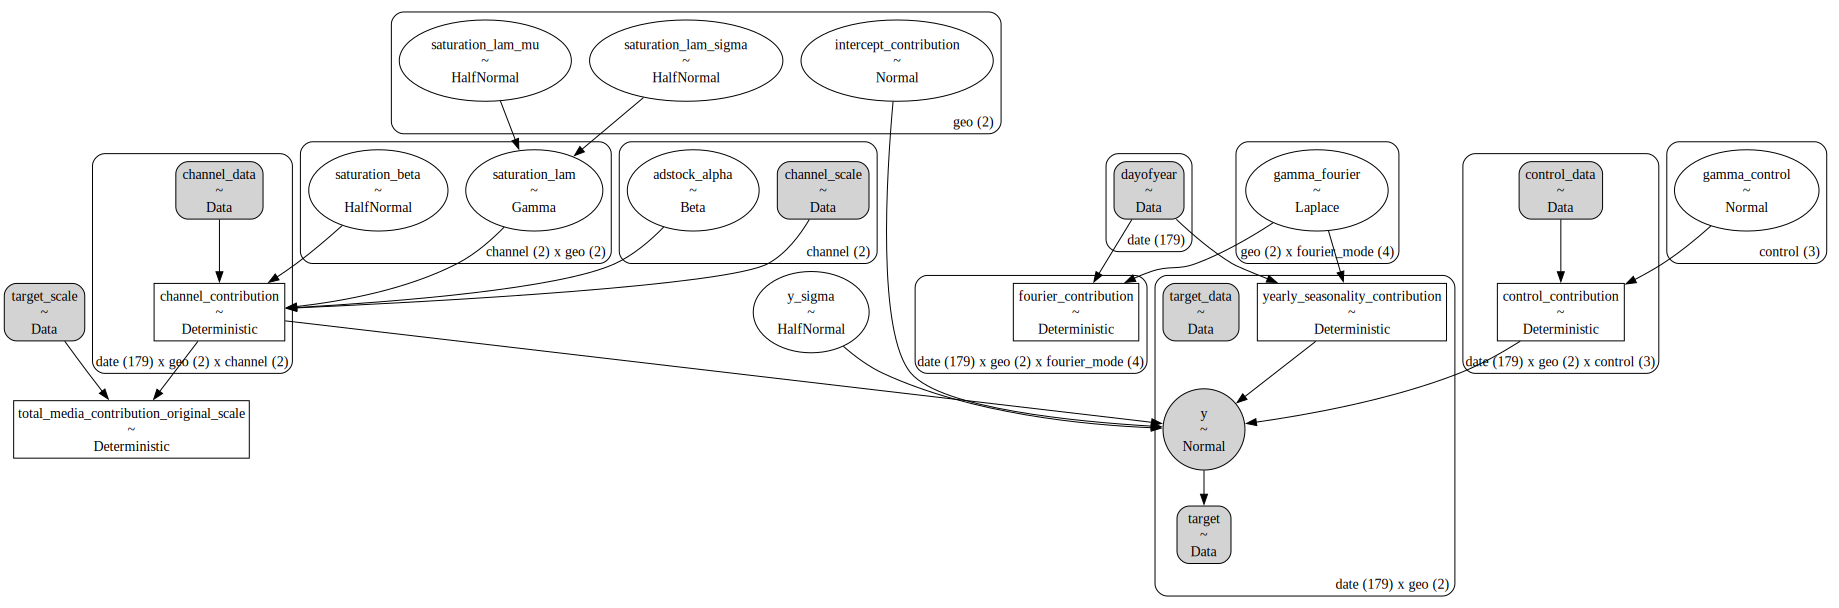

In [128]:
pm.model_to_graphviz(mmm.model)

In [129]:
mmm.add_original_scale_contribution_variable(
    var=["intercept_contribution", "channel_contribution"]
)

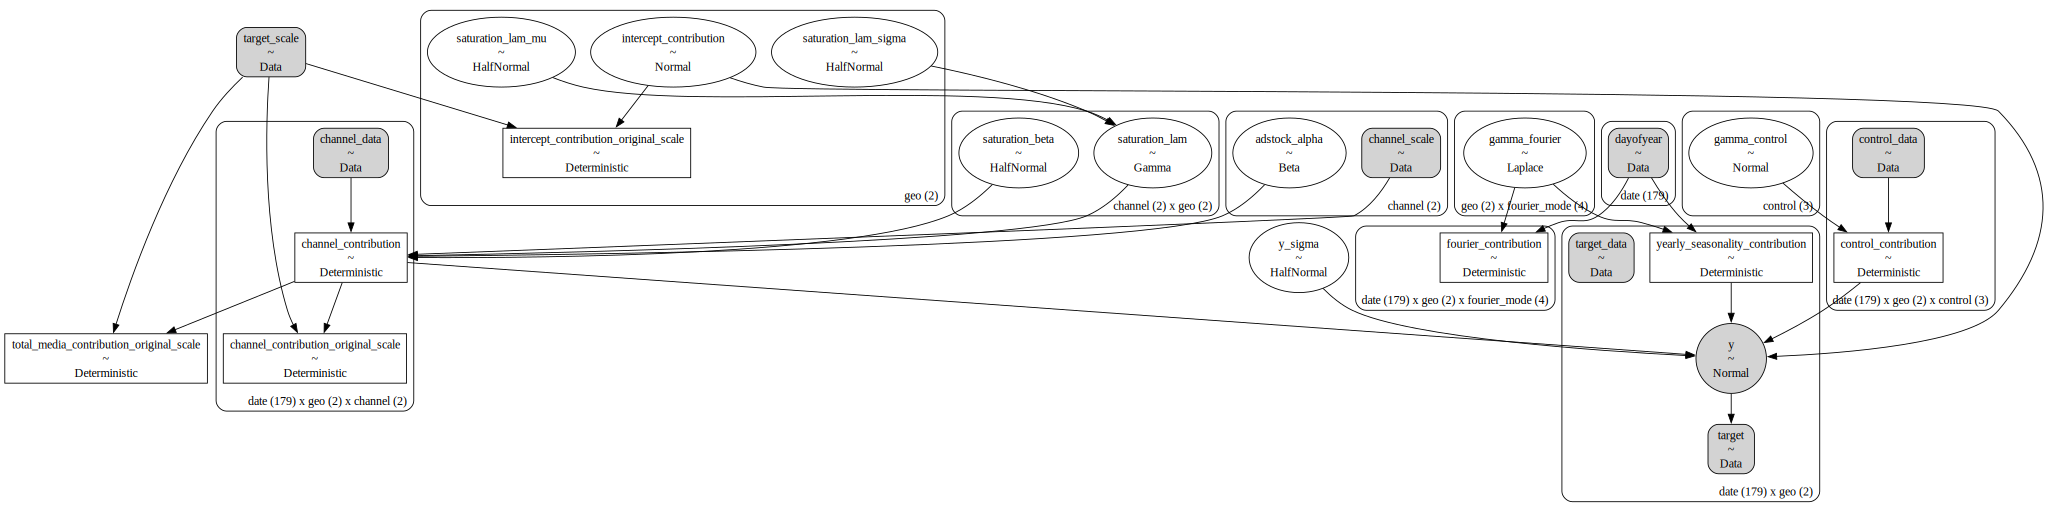

In [130]:
pm.model_to_graphviz(mmm.model)

In [131]:
prior_predictive = mmm.sample_prior_predictive(X=x_train, samples=1_000)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_mu, saturation_lam_sigma, y, y_sigma]


<Axes: >

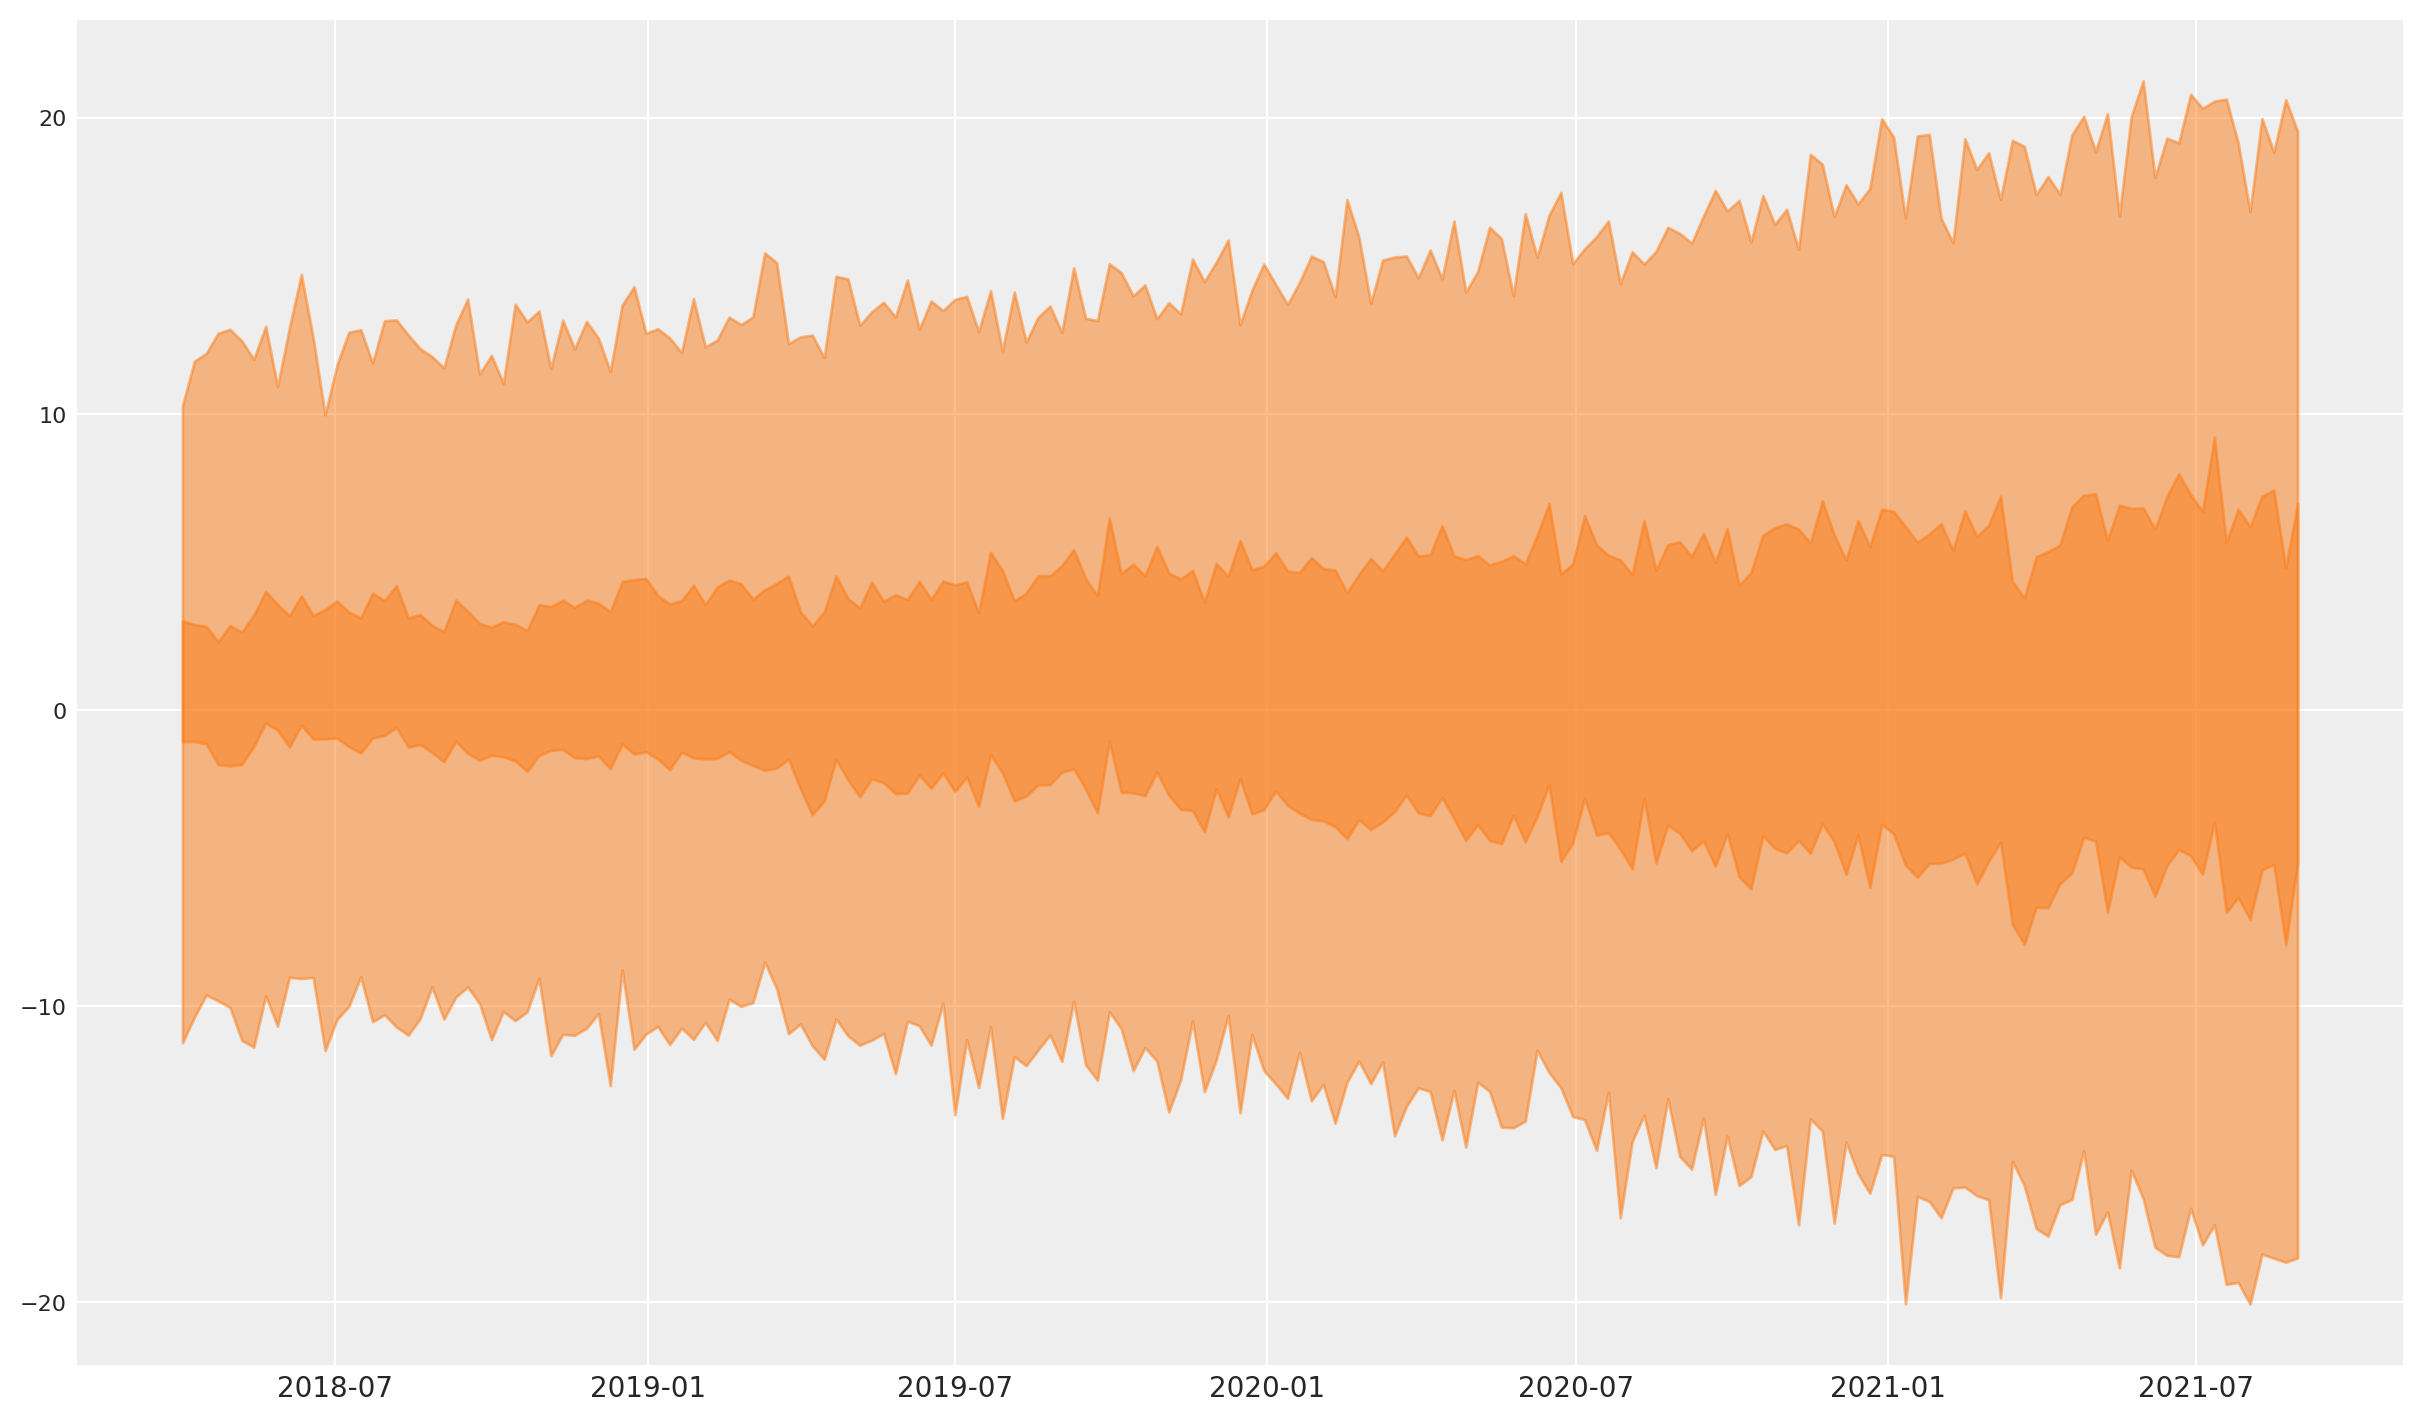

In [132]:
az.plot_hdi(
    x=mmm.model.coords["date"],
    y=prior_predictive.sel(geo="geo_a")["y"].unstack().transpose(..., "date"),
    smooth=False,
    hdi_prob=0.94,
)
az.plot_hdi(
    x=mmm.model.coords["date"],
    y=prior_predictive.sel(geo="geo_a")["y"].unstack().transpose(..., "date"),
    smooth=False,
    hdi_prob=0.5,
)

In [133]:
mmm.fit(
    X=data_df.drop(columns="y"),
    y=data_df["y"],
    chains=4,
    target_accept=0.9,
    nuts_sampler="numpyro",
    random_seed=42,
)

mmm.sample_posterior_predictive(
    X=data_df.drop(columns="y"),
    extend_idata=True,
    combined=True,
    random_seed=42,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


Output()

<xarray.Dataset> Size: 12MB
Dimensions:  (date: 179, geo: 2, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * geo      (geo) <U5 40B 'geo_a' 'geo_b'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, geo, sample) float64 11MB 0.388 0.5303 ... 0.2609 0.1961
Attributes:
    created_at:                 2025-02-27T13:44:46.575523+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

In [77]:
mmm.idata.sample_stats.diverging.sum().item()

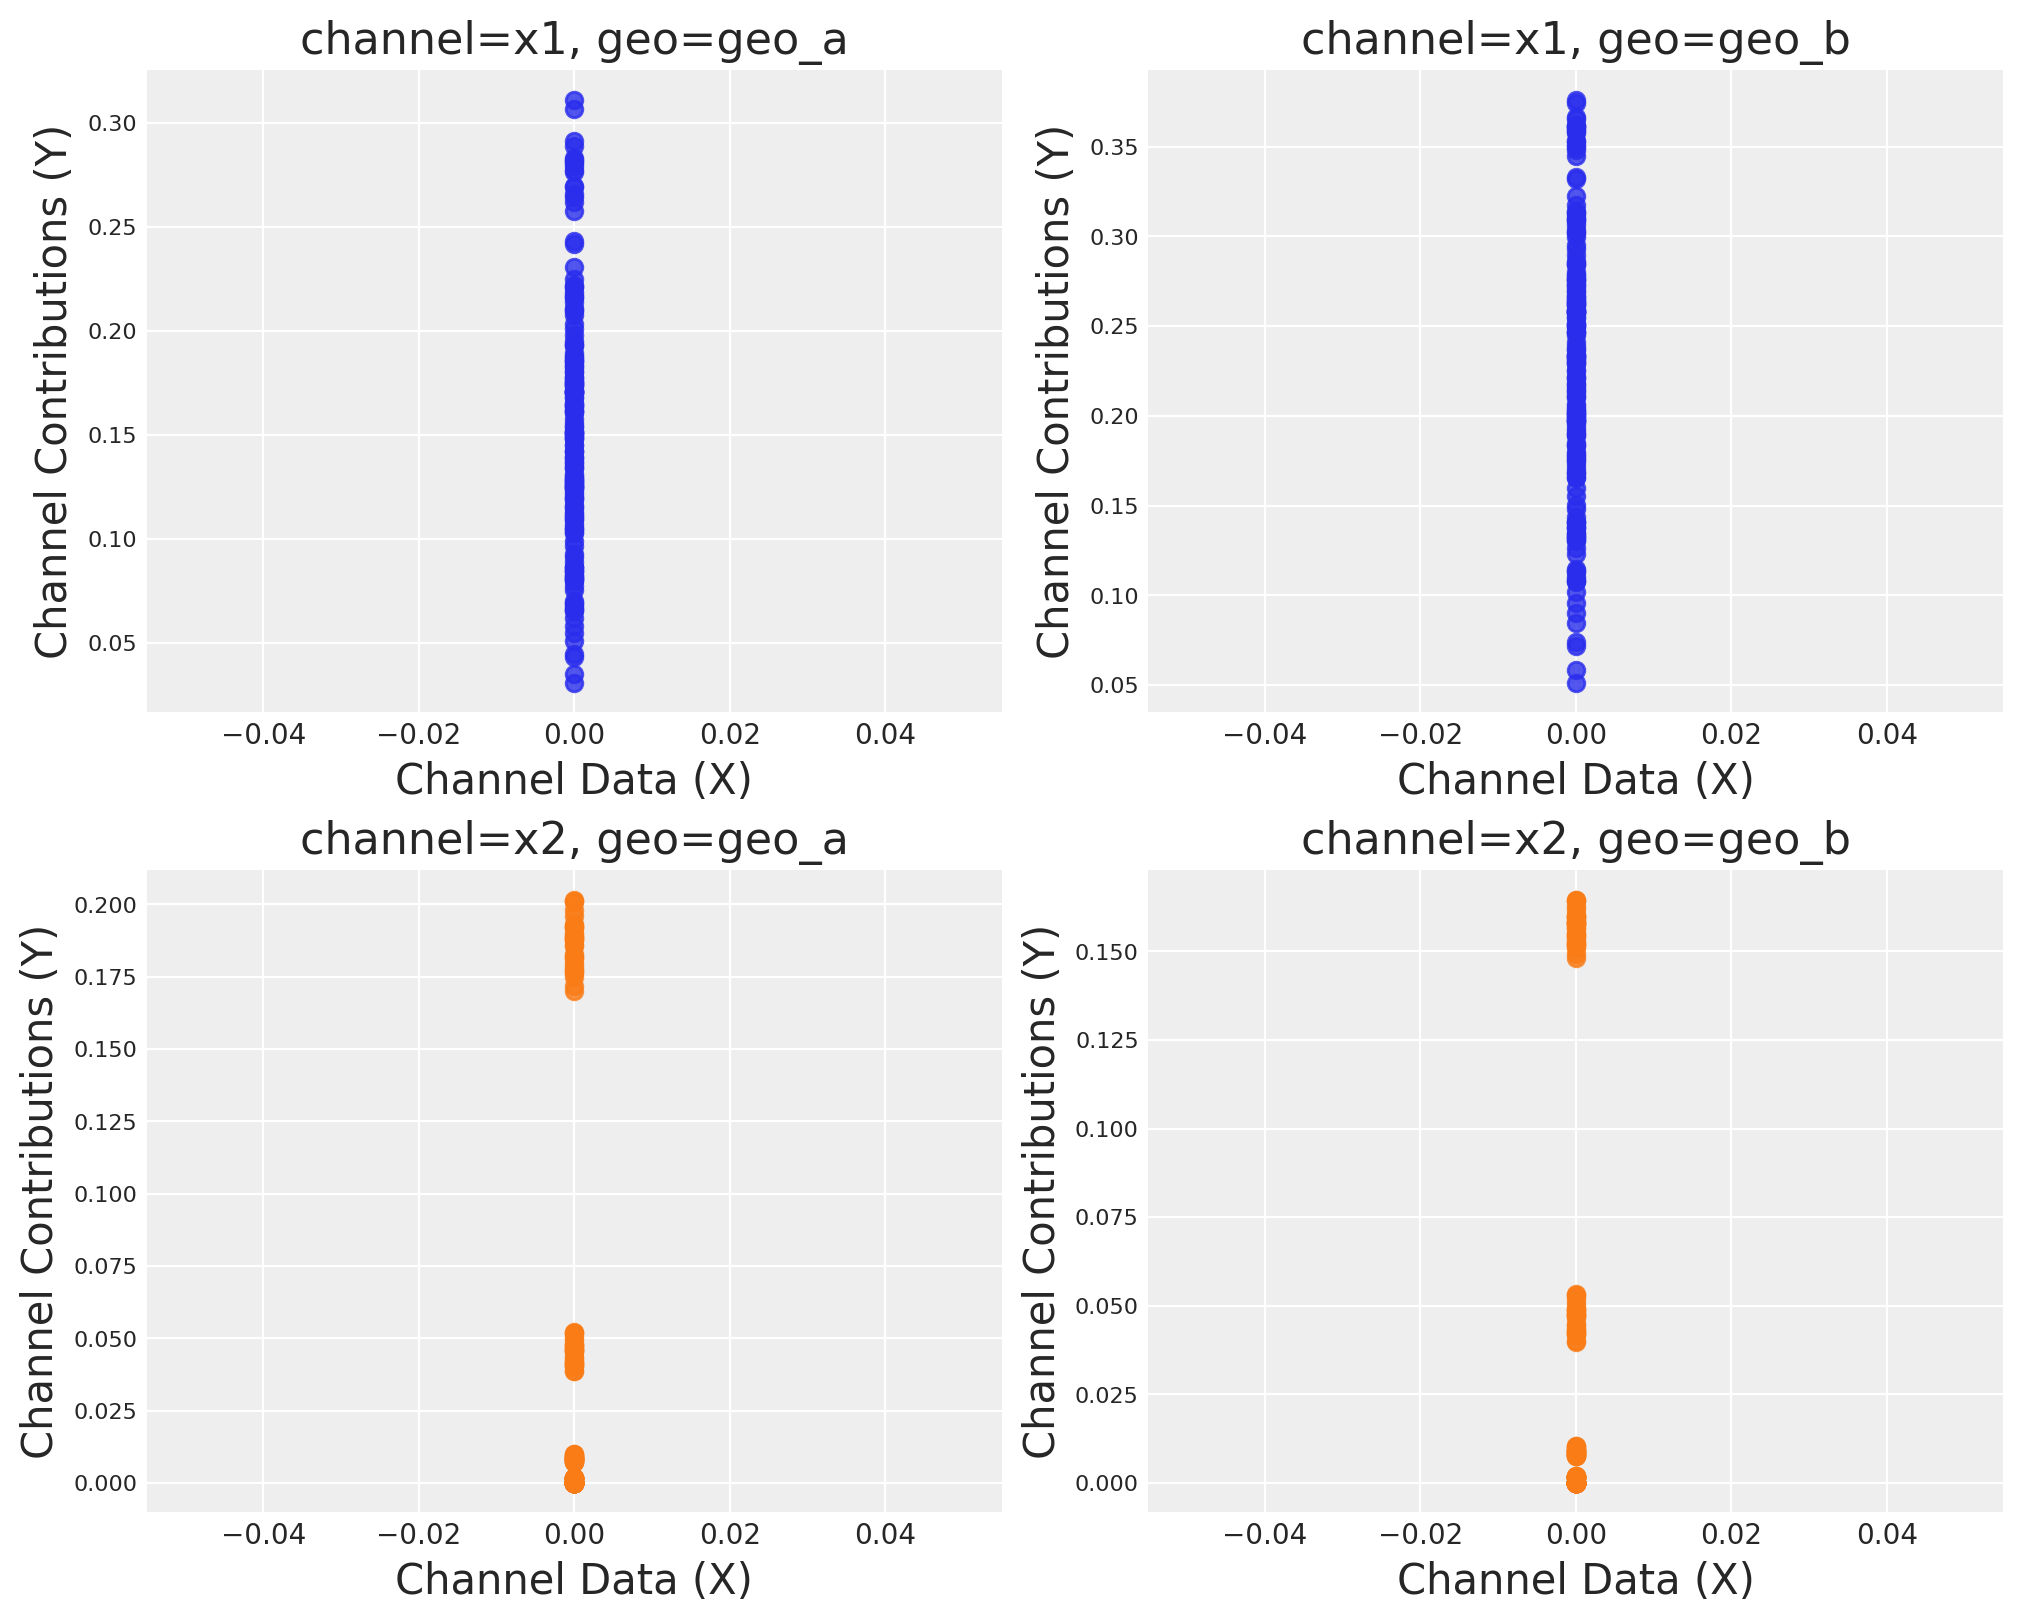

In [78]:
mmm.plot.saturation_curves_scatter();

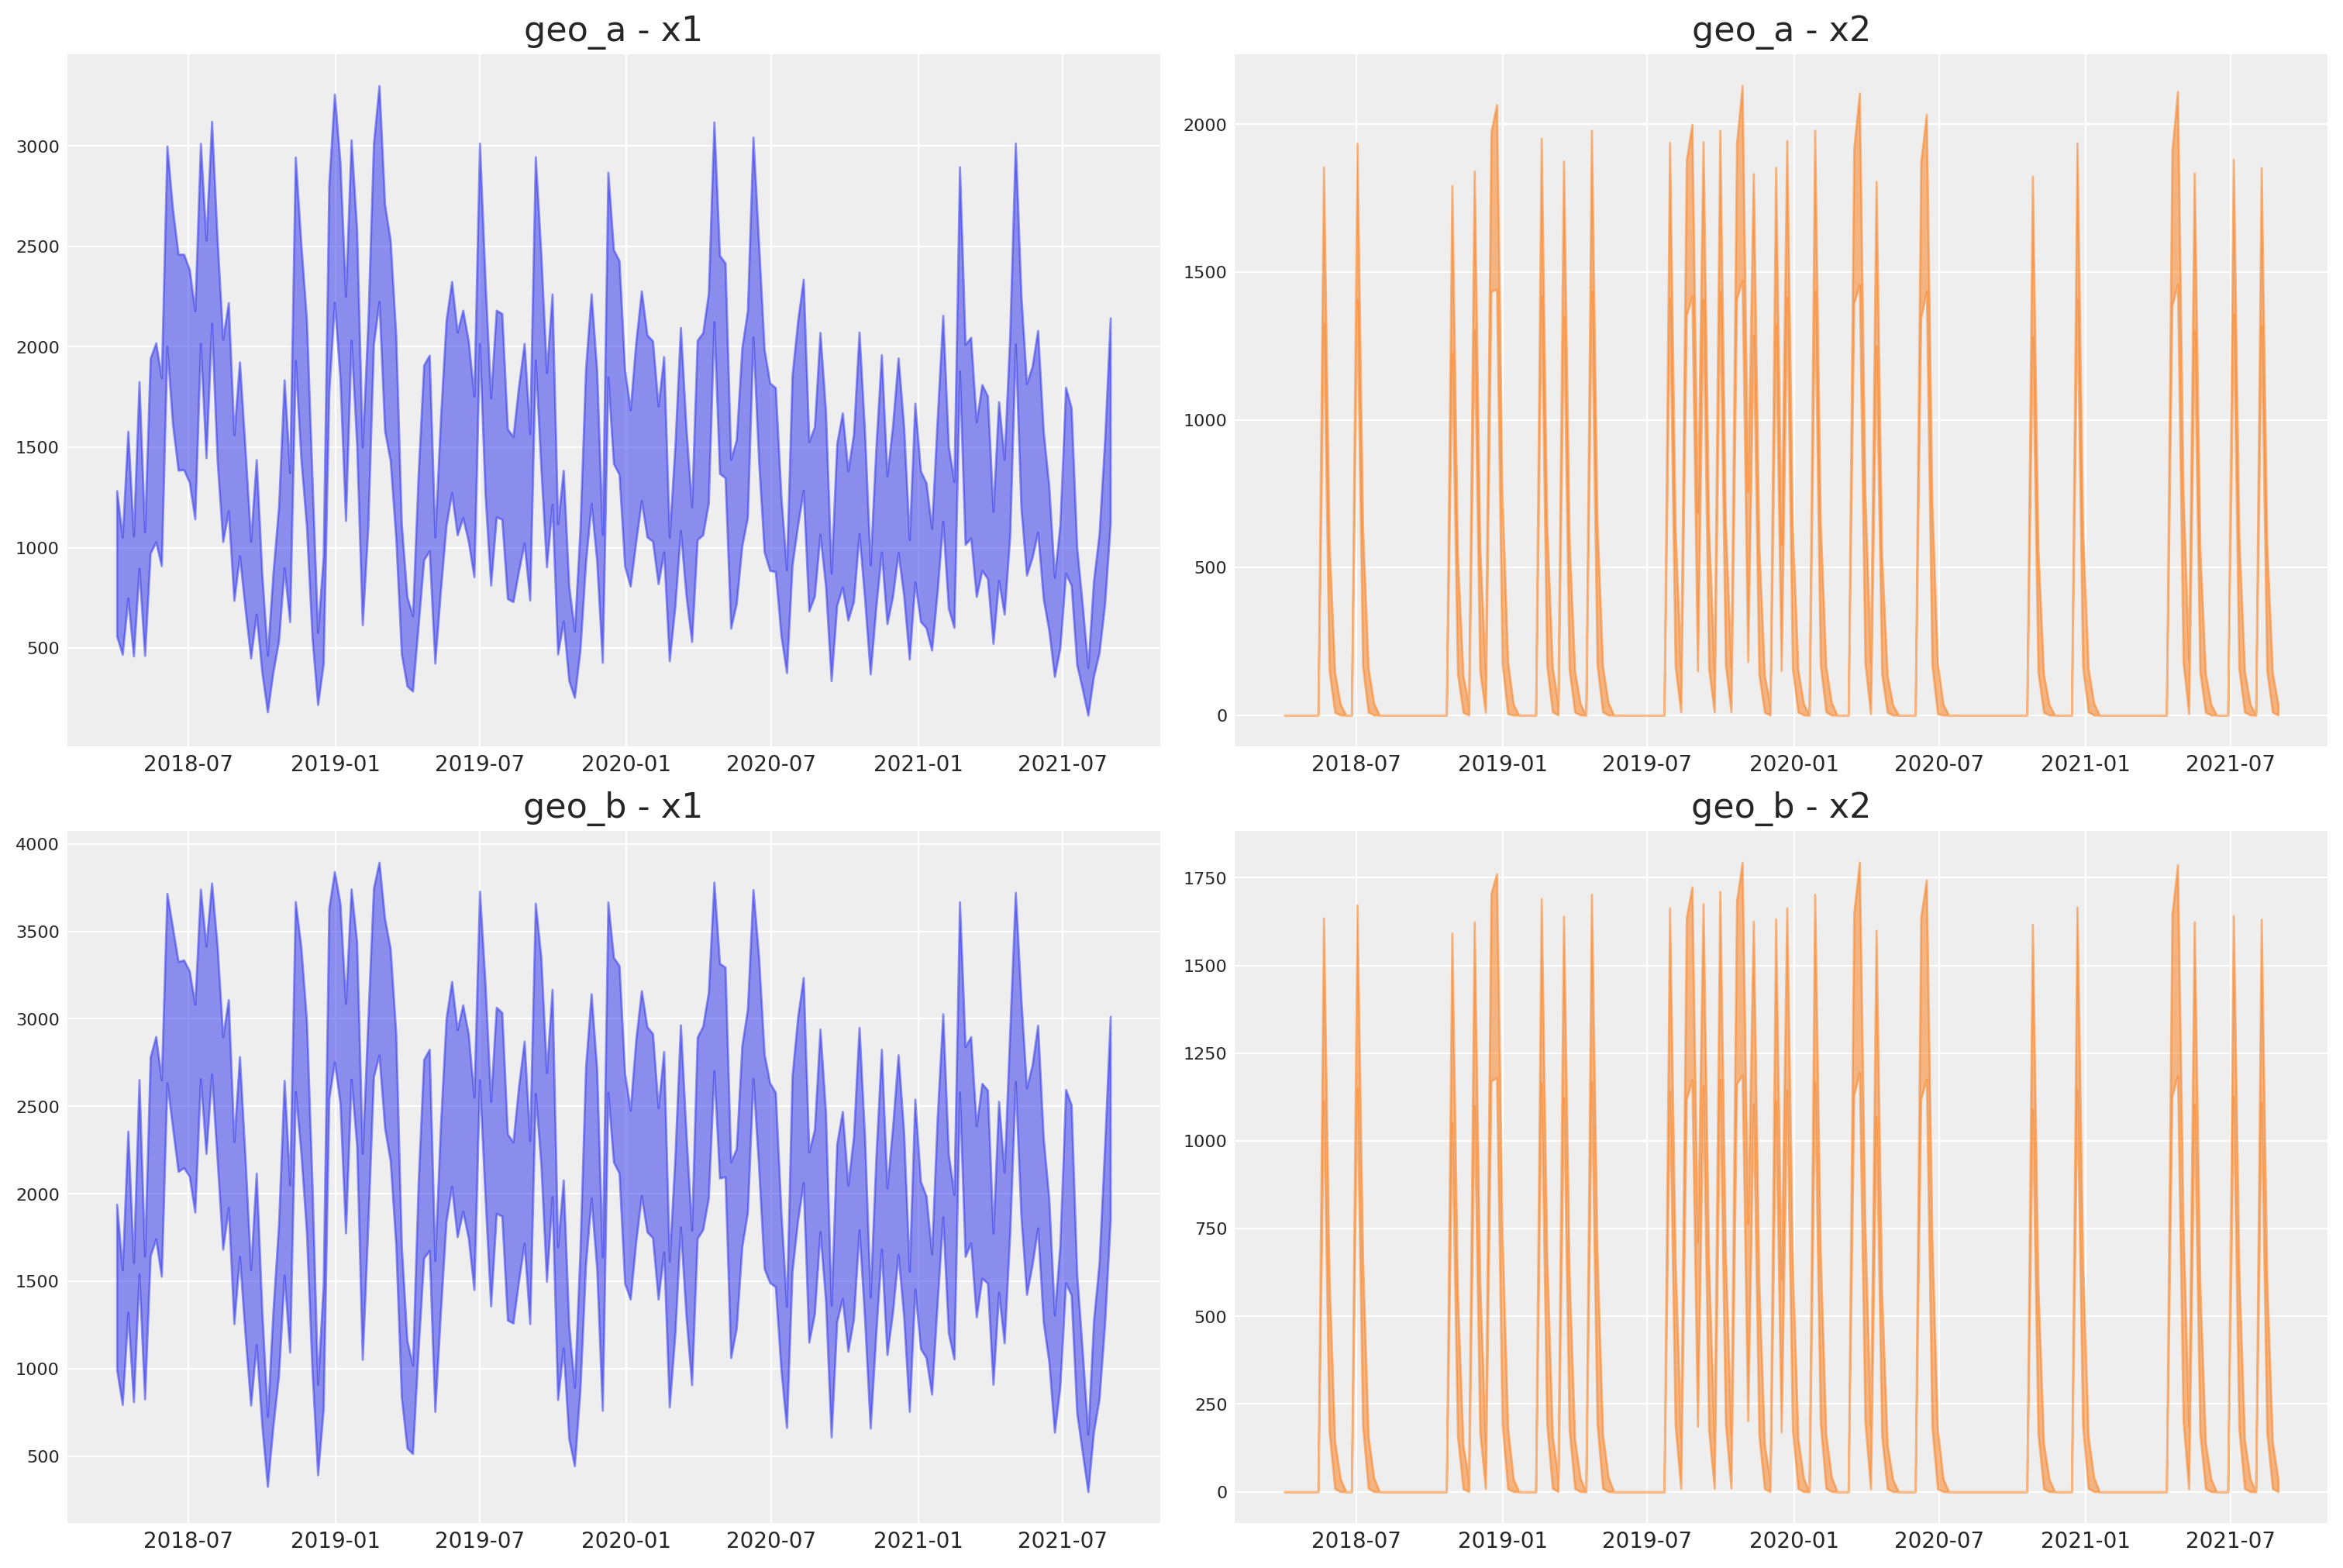

In [102]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    ncols=len(mmm.model.coords["channel"]),
    figsize=(15, 10),
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    for j, channel in enumerate(mmm.model.coords["channel"]):
        ax = axes[i, j]
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["channel_contribution_original_scale"].sel(
                geo=geo, channel=channel
            ),
            color=f"C{j}",
            smooth=False,
            hdi_prob=0.94,
            ax=ax,
        )
        ax.set_title(f"{geo} - {channel}")

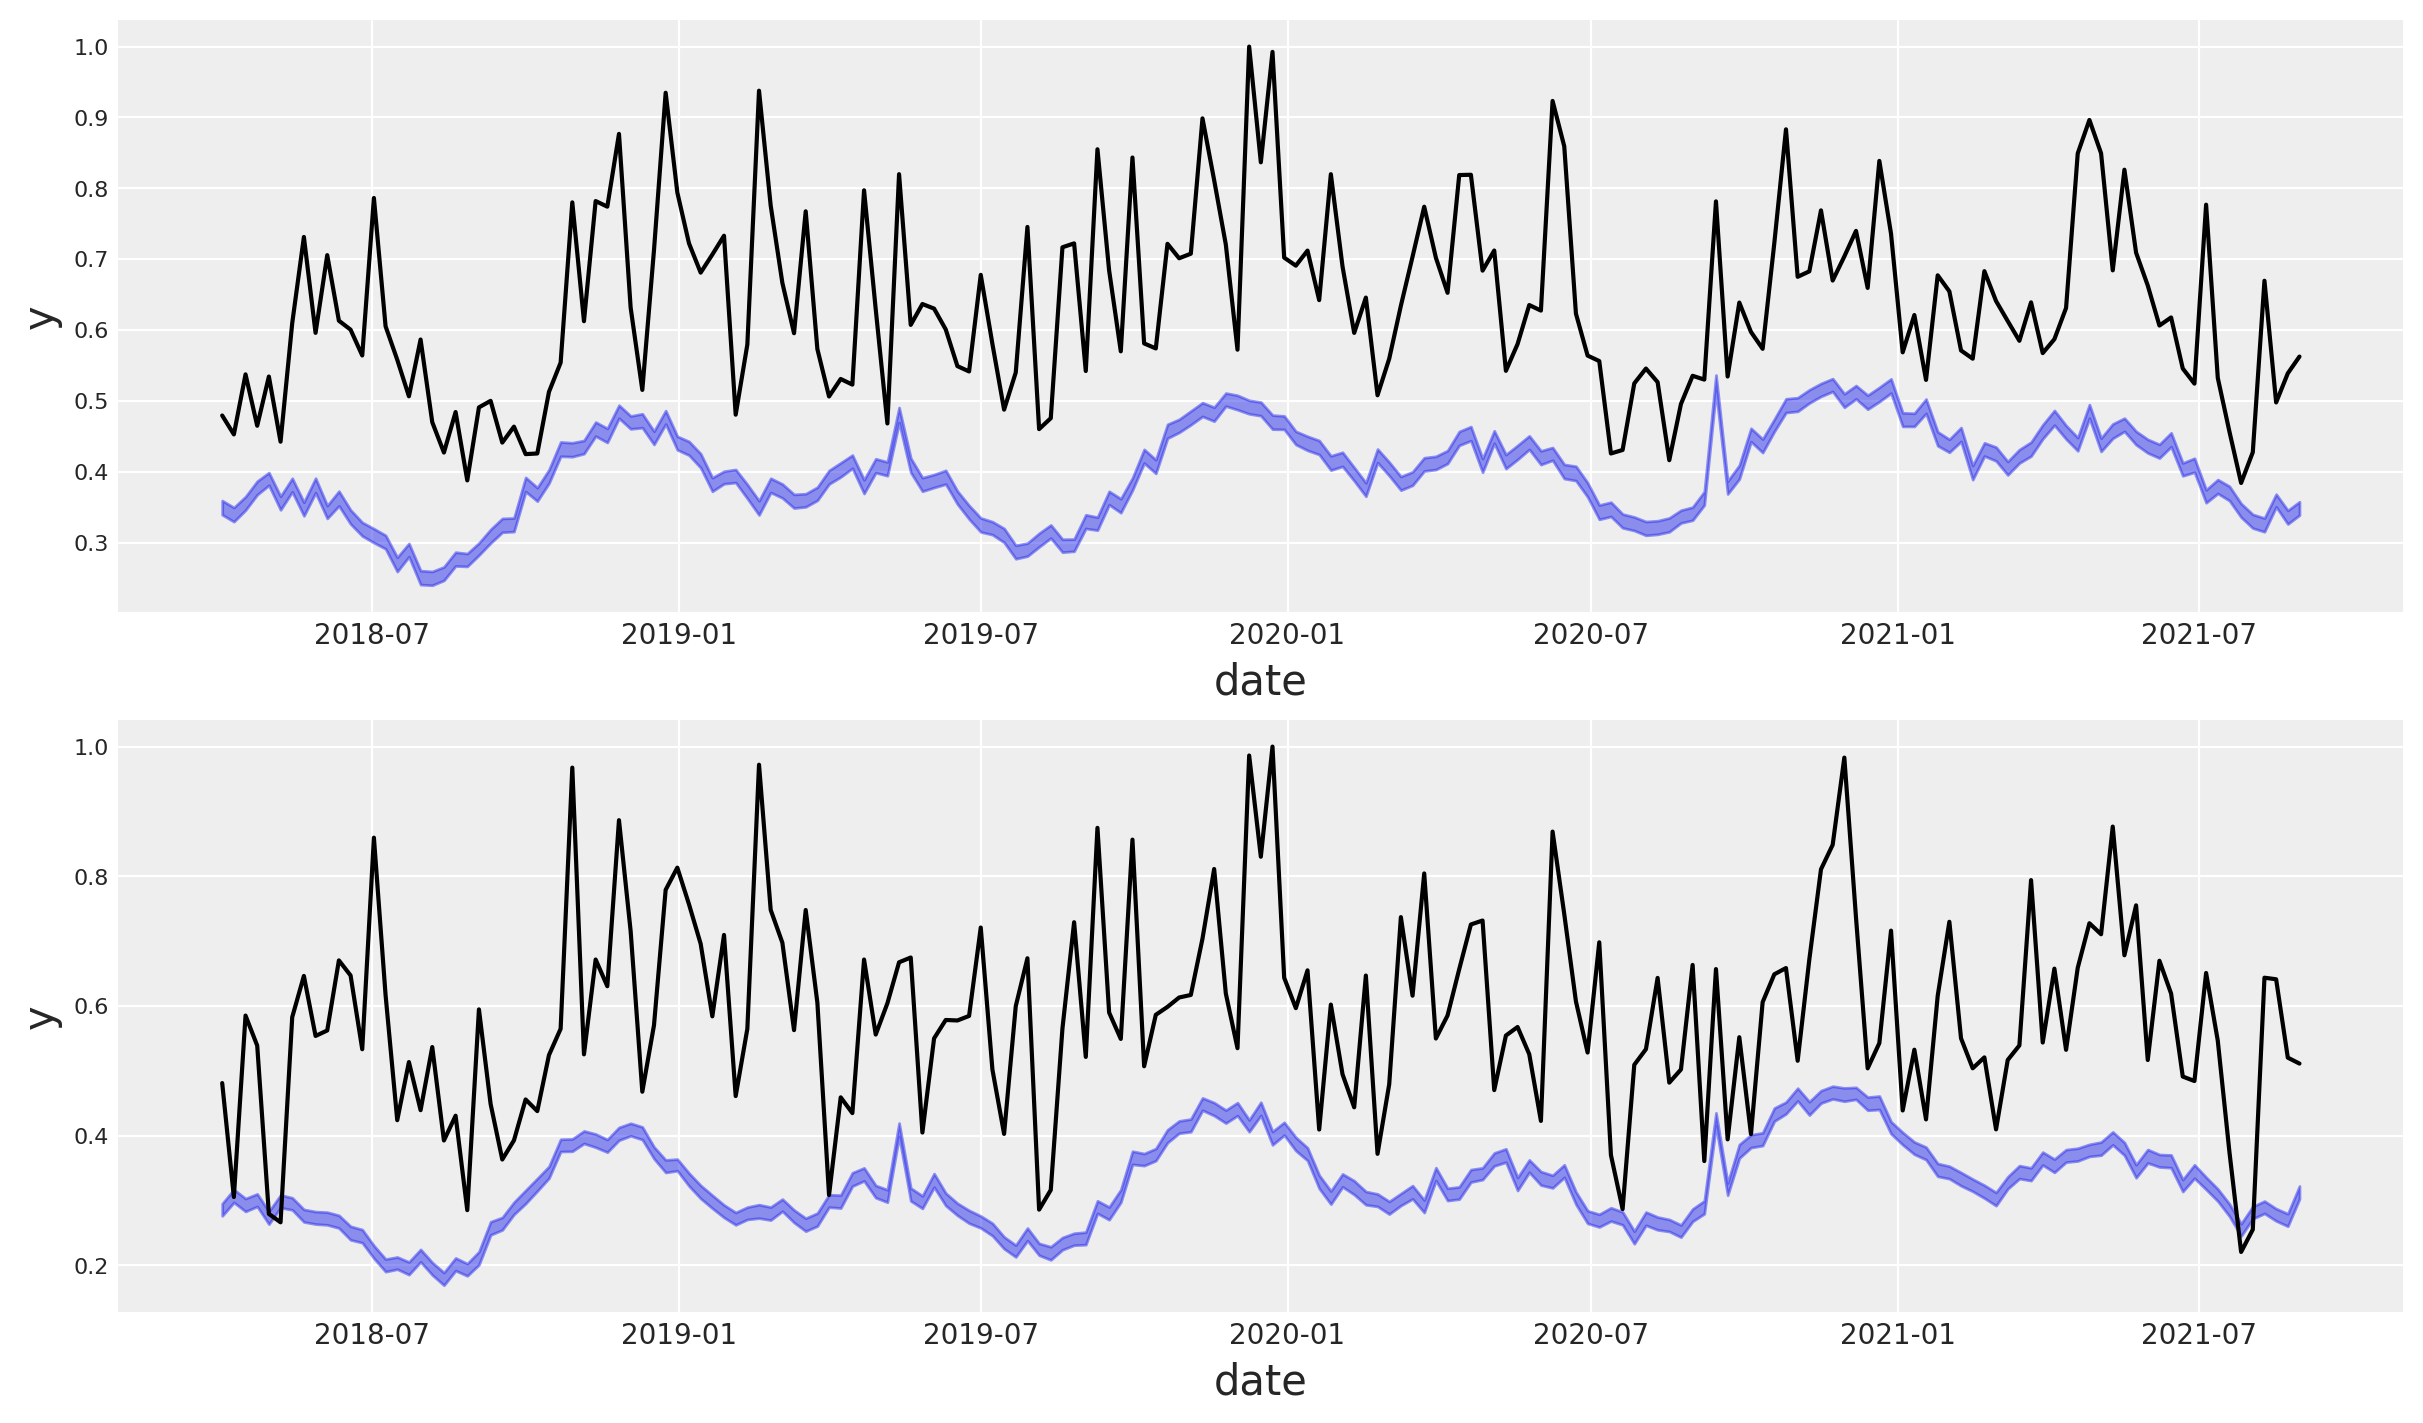

In [107]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior_predictive"].sel(geo=geo)["y"],
        color="C0",
        smooth=False,
        hdi_prob=0.1,
        ax=ax,
    )

    sns.lineplot(
        data=data_df.query("geo == @geo").assign(y=lambda x: x["y"] / x["y"].max()),
        x="date",
        y="y",
        color="black",
        ax=ax,
    )

In [27]:
_y_in_sample = mmm.sample_posterior_predictive(
    X=data_df.drop(columns="y"),
    extend_idata=False,
    include_last_observations=False,
    random_seed=42,
    var_names=["channel_contribution", "intercept_contribution"],
)

Sampling: [intercept_contribution]


Output()